Verwendetes Szenario: office
Erster Timestamp: 2025-05-22 00:00:00
Letzter Timestamp: 2025-05-24 23:50:00
Simulationshorizont: 3 Tage

Anzahl Ladesessions im Simulationshorizont: 47

Beispiel-Sessions (erste 10):
Max. gleichzeitig ladende Fahrzeuge: 4
Vorhandene Ladepunkte am Standort: 4
Fahrzeug: EX30 Twin, Ankunft: 2025-05-22 07:23:19.981060, Abfahrt: 2025-05-22 15:37:21.178699, Kapazität: 69.0 kWh, geladene Energie: 12.0 kWh, Restbedarf: 0.0 kWh
Fahrzeug: Cooper E, Ankunft: 2025-05-22 07:46:50.669869, Abfahrt: 2025-05-22 09:02:17.042298, Kapazität: 37.0 kWh, geladene Energie: 7.5 kWh, Restbedarf: 0.0 kWh
Fahrzeug: Q8 e-tron, Ankunft: 2025-05-22 07:48:03.070737, Abfahrt: 2025-05-22 14:28:51.570069, Kapazität: 89.0 kWh, geladene Energie: 26.1 kWh, Restbedarf: 0.0 kWh
Fahrzeug: IONIQ 6, Ankunft: 2025-05-22 07:52:52.081777, Abfahrt: 2025-05-22 15:25:42.769351, Kapazität: 77.0 kWh, geladene Energie: 19.2 kWh, Restbedarf: 0.0 kWh
Fahrzeug: Macan, Ankunft: 2025-05-22 08:33:45.723153, Abfah

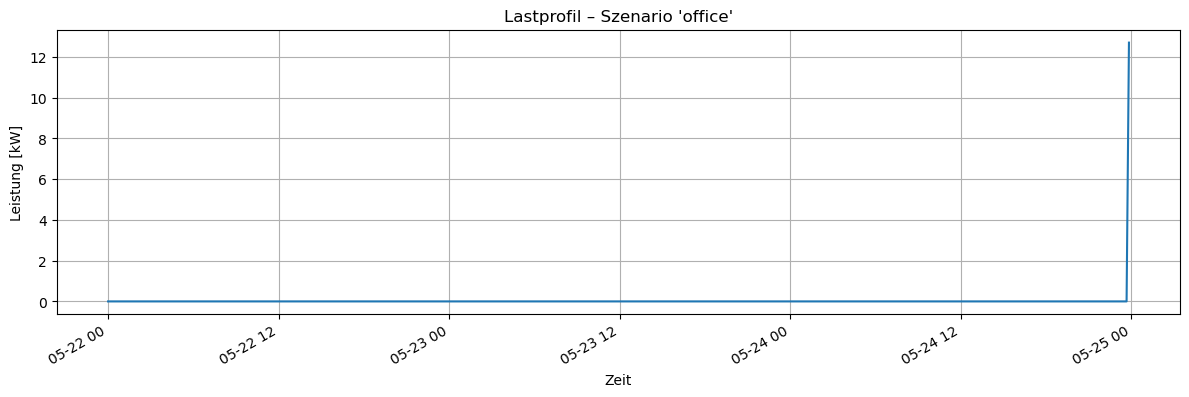

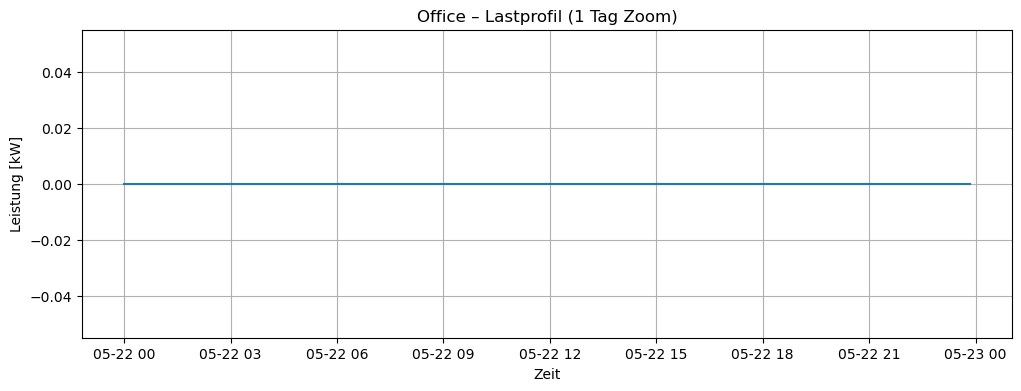

In [ ]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# ---------------------------------------------------------------------------
# Projektpfad setzen, damit "model" importierbar ist
# ---------------------------------------------------------------------------
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import (
    load_scenario,
    simulate_load_profile,
    load_vehicle_profiles_from_csv,
)

# ---------------------------------------------------------------------------
# Szenario laden und Simulation durchführen
# ---------------------------------------------------------------------------
scenario_name = "office"            # gewünschtes Szenario
scenario_path = f"../scenarios/{scenario_name}.yaml"

scenario = load_scenario(scenario_path)
timestamps, load_kw, sessions, charging_counts = simulate_load_profile(scenario)

# ---------------------------------------------------------------------------
# Kontrollen: Standorttyp, Zeitbereich und Simulationshorizont
# ---------------------------------------------------------------------------
print("Verwendetes Szenario:", scenario_name)
print(f"Erster Timestamp: {timestamps[0]}")
print(f"Letzter Timestamp: {timestamps[-1]}")
print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")

# ---------------------------------------------------------------------------
# Überblick: Anzahl Sessions und Beispiel-Sessions
# ---------------------------------------------------------------------------
print("\nAnzahl Ladesessions im Simulationshorizont:", len(sessions))
print("\nBeispiel-Sessions (erste 10):")
print("Max. gleichzeitig ladende Fahrzeuge:", max(charging_counts))
print("Vorhandene Ladepunkte am Standort:", scenario["site"]["number_chargers"])


for s in sessions[:10]:
    print(
        f"Fahrzeug: {s['vehicle_name']}, "
        f"Ankunft: {s['arrival_time']}, "
        f"Abfahrt: {s['departure_time']}, "
        f"Kapazität: {s['battery_capacity_kwh']} kWh, "
        f"geladene Energie: {s['delivered_energy_kwh']:.1f} kWh, "      #NEU
        f"Restbedarf: {s['energy_required_kwh']:.1f} kWh"           # NEU
    )

# ---------------------------------------------------------------------------
# Auswertung: welche Fahrzeuge wurden wie oft geladen?
# ---------------------------------------------------------------------------
vehicle_names = [s["vehicle_name"] for s in sessions]
counts = Counter(vehicle_names)

print("\nVerwendete Fahrzeuge im Simulationshorizont:")
for model, n in counts.items():
    print(f"- {model}: {n} Sessions")


# ---------------------------------------------------------------------------
# 3) Lastprofil als Diagramm
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(timestamps, load_kw)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(f"Lastprofil – Szenario '{scenario_name}'")
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

steps_per_day = int(24*60/scenario["time_resolution_min"])

plt.figure(figsize=(12,4))
plt.plot(timestamps[:steps_per_day], load_kw[:steps_per_day])
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title("Office – Lastprofil (1 Tag Zoom)")
plt.grid(True)
plt.show()

